In [62]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/func.ipynb
%matplotlib inline

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39125")
client

<Client: 'tcp://127.0.0.1:39125' processes=5 threads=20, memory=78.51 GiB>

In [ ]:
client.close()

# Open CMIP6 online catalog & download desired data

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])
waccm.df
cam.df

  activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP           NCAR  CESM2-WACCM    historical  r1i1p1f1     Amon   
1        CMIP           NCAR  CESM2-WACCM    historical  r2i1p1f1     Amon   
2        CMIP           NCAR  CESM2-WACCM    historical  r3i1p1f1     Amon   

  variable_id grid_label                                             zstore  \
0          o3         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...   
1          o3         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...   
2          o3         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...   

   dcpp_init_year   version  
0             NaN  20190415  
1             NaN  20190415  
2             NaN  20190415  
  activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP           NCAR     CESM2    historical  r1i1p1f1     Amon   
1        CMIP           NCAR     CESM2    historical  r2i1p1f1     Amon   
2        CMIP           N

In [6]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True}, cdf_kwargs={"chunks": {"time": 40}})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True},cdf_kwargs={"chunks": {"time": 4}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
ds_waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


# Rechunk the dataset to optimize dask

In [91]:
# Each worker should have en even number of workload. 
# For this dataset I have time:1980 divided by 5 gives me an even number of 396.
# I should therefore have 5 workers when using dask.
# This will also wotk if I decide to calculate the yearly mean. 
# I have 165 years. 5 workers will then each have 33 years to work on simultaneously 

# This dataset is already chunked as wished, no need to change

# If change is needed:
#ds_waccm.chunk(time=33).chunks
#ds_waccm.o3[0]

Frozen({'lat': (192,), 'nbnd': (2,), 'lon': (288,), 'member_id': (1, 1, 1), 'time': (33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33), 'plev': (19,)})

# Select time period 
# This is for Mount Pinatubo eruption

In [46]:
start = cftime.DatetimeNoLeap(1985,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
ds_waccm_1986_1996 = ds_waccm.sel(time=slice(start, end))
# CAM
ds_cam_1986_1996 = ds_cam.sel(time=slice(start, end))

## Calculate ozone from concentration to Dobson units

In [47]:
# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_1986_1996 = calculate_total_ozone_p(ds_waccm_1986_1996)
ds_cam_1986_1996 = calculate_total_ozone_p(ds_cam_1986_1996)

Minimum column ozone value: 58.61533162268342
Minimum column ozone value: 123.06848968692877


## Calculate the anomaly

In [75]:
# Select 5 years post volcanic eruption to see the effect on the ozone
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)

# WACCM
ds_waccm_post_eruption = ds_waccm_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_waccm_climatology = ds_waccm_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_waccm_anomaly = ds_waccm_post_eruption - ds_waccm_climatology
ds_waccm_anomaly.attrs = ds_waccm_climatology.attrs

# CAM
ds_cam_post_eruption = ds_cam_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_cam_climatology = ds_cam_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_cam_anomaly = ds_cam_post_eruption - ds_cam_climatology
ds_cam_anomaly.attrs = ds_cam_climatology.attrs

## Calculate the weights

In [80]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_wgt_NH_anom = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']>60.)).compute()
waccm_wgt_SH_anom = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']<-60.)).compute()

# CAM
cam_wgt_NH_anom = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']>60.)).compute()
cam_wgt_SH_anom = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']<-60.)).compute()

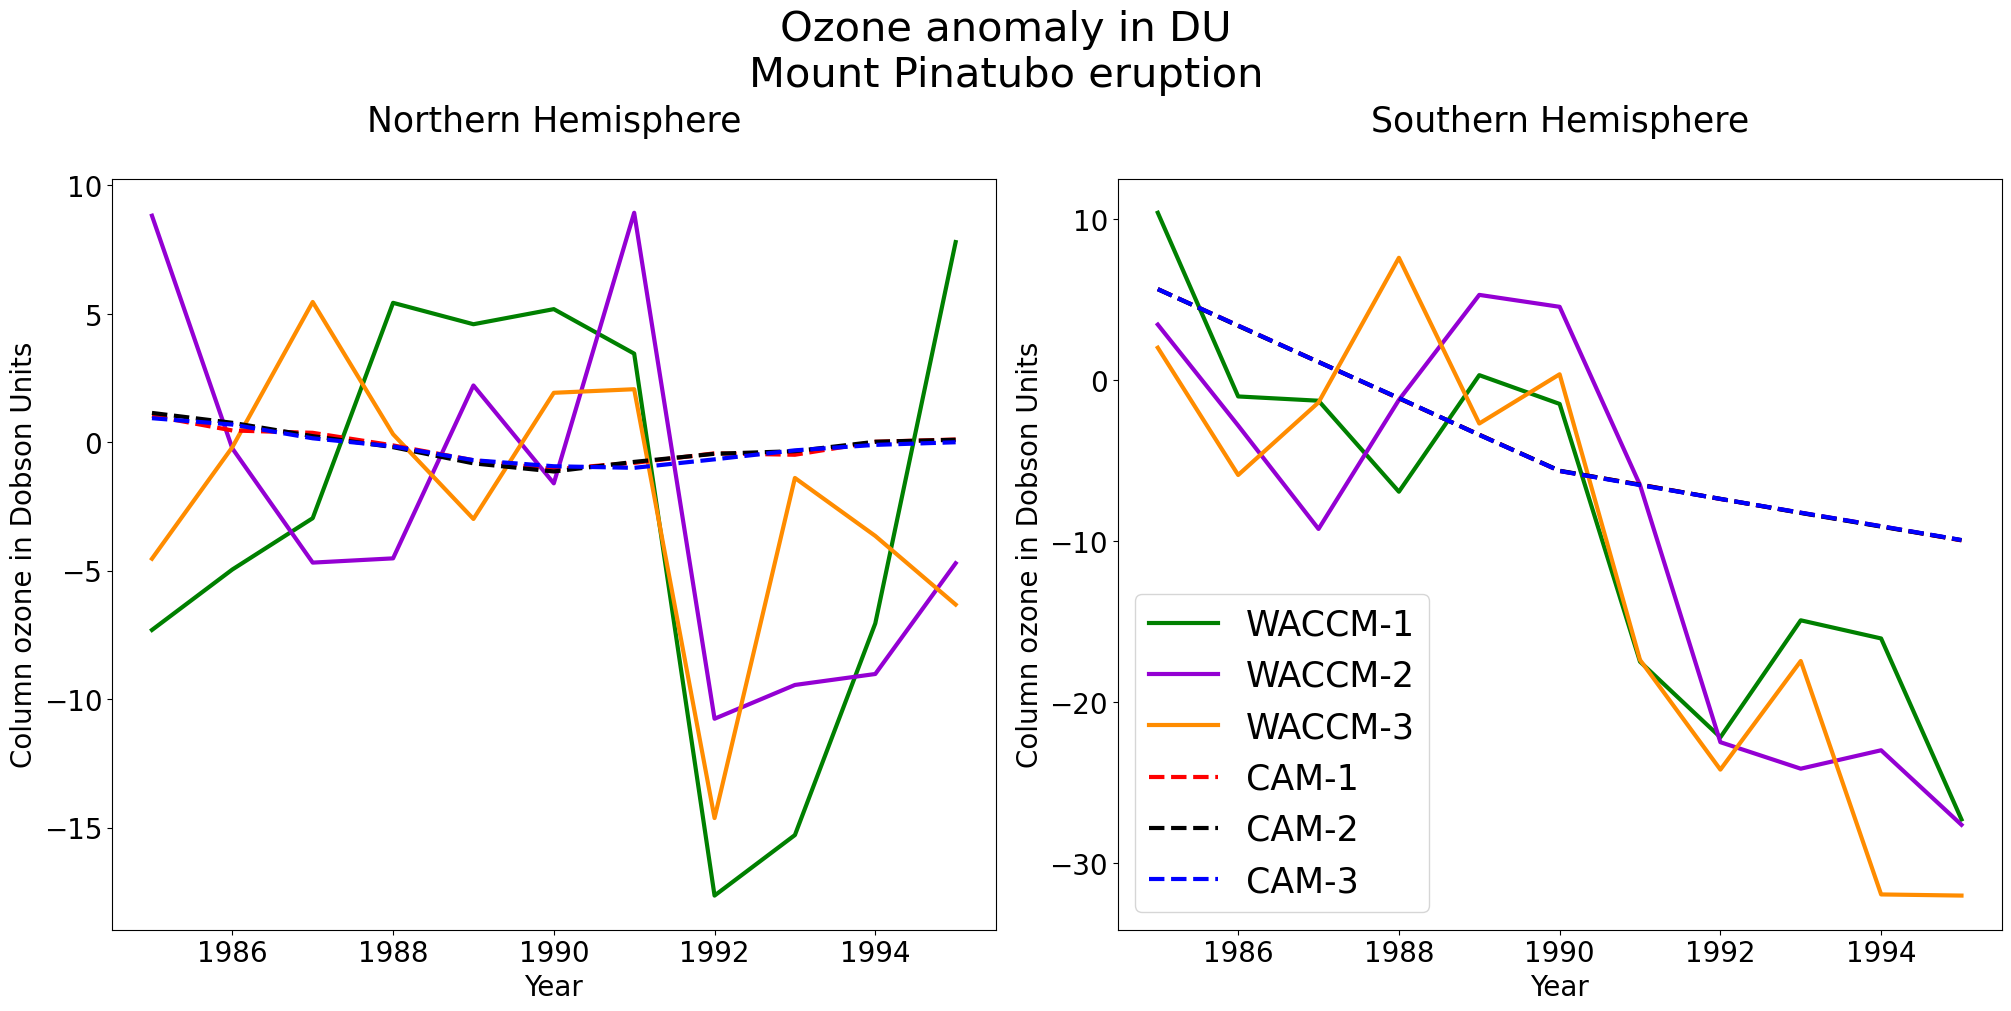

In [127]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
color_cam = ['red','black','blue']
color_waccm = ['green','darkviolet','darkorange']

for i in range(3):
    j = i+1
    waccm_weight_north_anomaly[i].plot(label="WACCM-"+ str(j), ax=axs1, linewidth=3, color=color_waccm[i])
    waccm_weight_south_anomaly[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color_waccm[i])

for i in range(3):
    j = i+1
    cam_weight_north_anomaly[i].plot(label="CAM-"+ str(j), ax=axs1, linestyle='--', linewidth=3, color=color_cam[i])
    cam_weight_south_anomaly[i].plot(label="CAM-"+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color_cam[i])

fig.suptitle('Ozone anomaly in DU\nMount Pinatubo eruption', fontsize=30)


axs1.set_ylabel(waccm_weight_south_anomaly[0].long_name, fontsize=20)
axs2.set_ylabel(cam_weight_south_anomaly[0].long_name, fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=25)
axs2.set_title(" Southern Hemisphere \n" , fontsize=25)

plt.legend(fontsize=25)

# Select time period

# This is for Sarychev Peak eruption

In [59]:
start_sary = cftime.DatetimeNoLeap(2005,1,15)
end_sary = cftime.DatetimeNoLeap(2015,1,15)

# WACCM
ds_waccm_2005_2015 = ds_waccm.sel(time=slice(start_sary, end_sary))
# CAM
ds_cam_2005_2015 = ds_cam.sel(time=slice(start_sary, end_sary))

# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_2005_2015 = calculate_total_ozone_p(ds_waccm_2005_2015)
ds_cam_2005_2015 = calculate_total_ozone_p(ds_cam_2005_2015)

Minimum column ozone value: 87.13288016154421
Minimum column ozone value: 118.49001039767961


In [58]:
def calc_yearly_anomaly(ds,end_prior_eruption):
    start = ds.totO3[0].time[0].values
    end_prior_eruption = cftime.DatetimeNoLeap(end_prior_eruption,1,15)
    ds_post_eruption = ds['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
    ds_climatology = ds['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
    ds_anomaly = ds_post_eruption - ds_climatology
    ds_anomaly.attrs = ds_climatology.attrs
    return ds_anomaly

In [63]:
ds_waccm_anom_2005_2015 = calc_yearly_anomaly(ds_waccm_2005_2015,2009)
ds_cam_anom_2005_2015 = calc_yearly_anomaly(ds_cam_2005_2015,2009)

In [65]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_wgt_north_anomaly = computeWeightedMean(ds_waccm_anom_2005_2015.where(ds_waccm_anom_2005_2015['lat']>60.)).compute()
waccm_wgt_south_anomaly = computeWeightedMean(ds_waccm_anom_2005_2015.where(ds_waccm_anom_2005_2015['lat']<-60.)).compute()

# CAM
cam_wgt_north_anomaly = computeWeightedMean(ds_cam_anom_2005_2015.where(ds_cam_anom_2005_2015['lat']>60.)).compute()
cam_wgt_south_anomaly = computeWeightedMean(ds_cam_anom_2005_2015.where(ds_cam_anom_2005_2015['lat']<-60.)).compute()

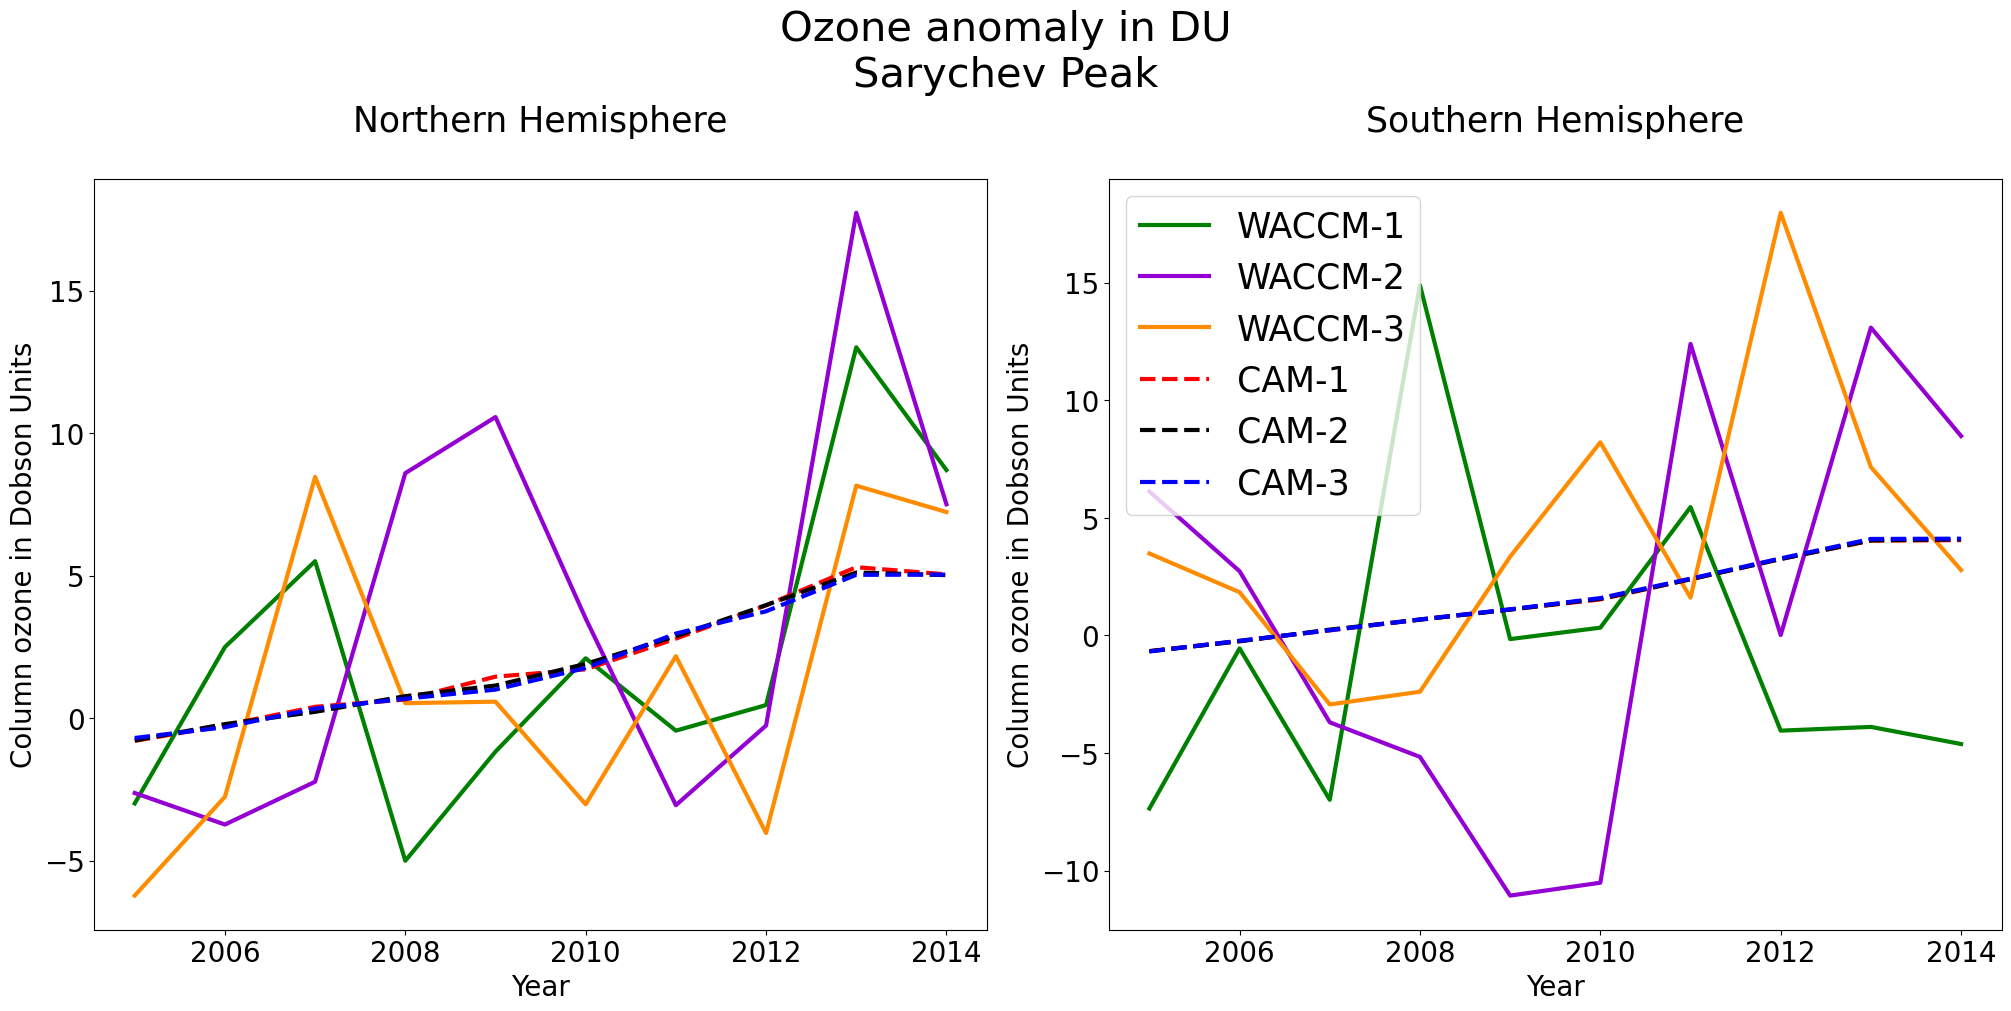

In [84]:
plot_year(waccm_wgt_NH_anom,waccm_wgt_SH_anom,cam_wgt_NH_anom,cam_wgt_SH_anom, 'Ozone anomaly in DU \nSarychev Peak')

# Krakatau

In [77]:
start_krak = cftime.DatetimeNoLeap(1877,1,15)
end_krak = cftime.DatetimeNoLeap(1887,1,15)

# WACCM
ds_waccm_1877_1887 = ds_waccm.sel(time=slice(start_krak, end_krak))
# CAM
ds_cam_1877_1887 = ds_cam.sel(time=slice(start_krak, end_krak))

# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_1877_1887 = calculate_total_ozone_p(ds_waccm_1877_1887)
ds_cam_1877_1887 = calculate_total_ozone_p(ds_cam_1877_1887)

Minimum column ozone value: 162.8951380411102
Minimum column ozone value: 176.09250962392275


In [79]:
ds_waccm_anom_1877_1887 = calc_yearly_anomaly(ds_waccm_1877_1887,1883)
ds_cam_anom_1877_1887 = calc_yearly_anomaly(ds_cam_1877_1887,1883)

In [80]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_wgt_NH_anom_krak = computeWeightedMean(ds_waccm_anom_1877_1887.where(ds_waccm_anom_1877_1887['lat']>60.)).compute()
waccm_wgt_SH_anom_krak = computeWeightedMean(ds_waccm_anom_1877_1887.where(ds_waccm_anom_1877_1887['lat']<-60.)).compute()

# CAM
cam_wgt_NH_anom_krak = computeWeightedMean(ds_cam_anom_1877_1887.where(ds_cam_anom_1877_1887['lat']>60.)).compute()
cam_wgt_SH_anom_krak = computeWeightedMean(ds_cam_anom_1877_1887.where(ds_cam_anom_1877_1887['lat']<-60.)).compute()

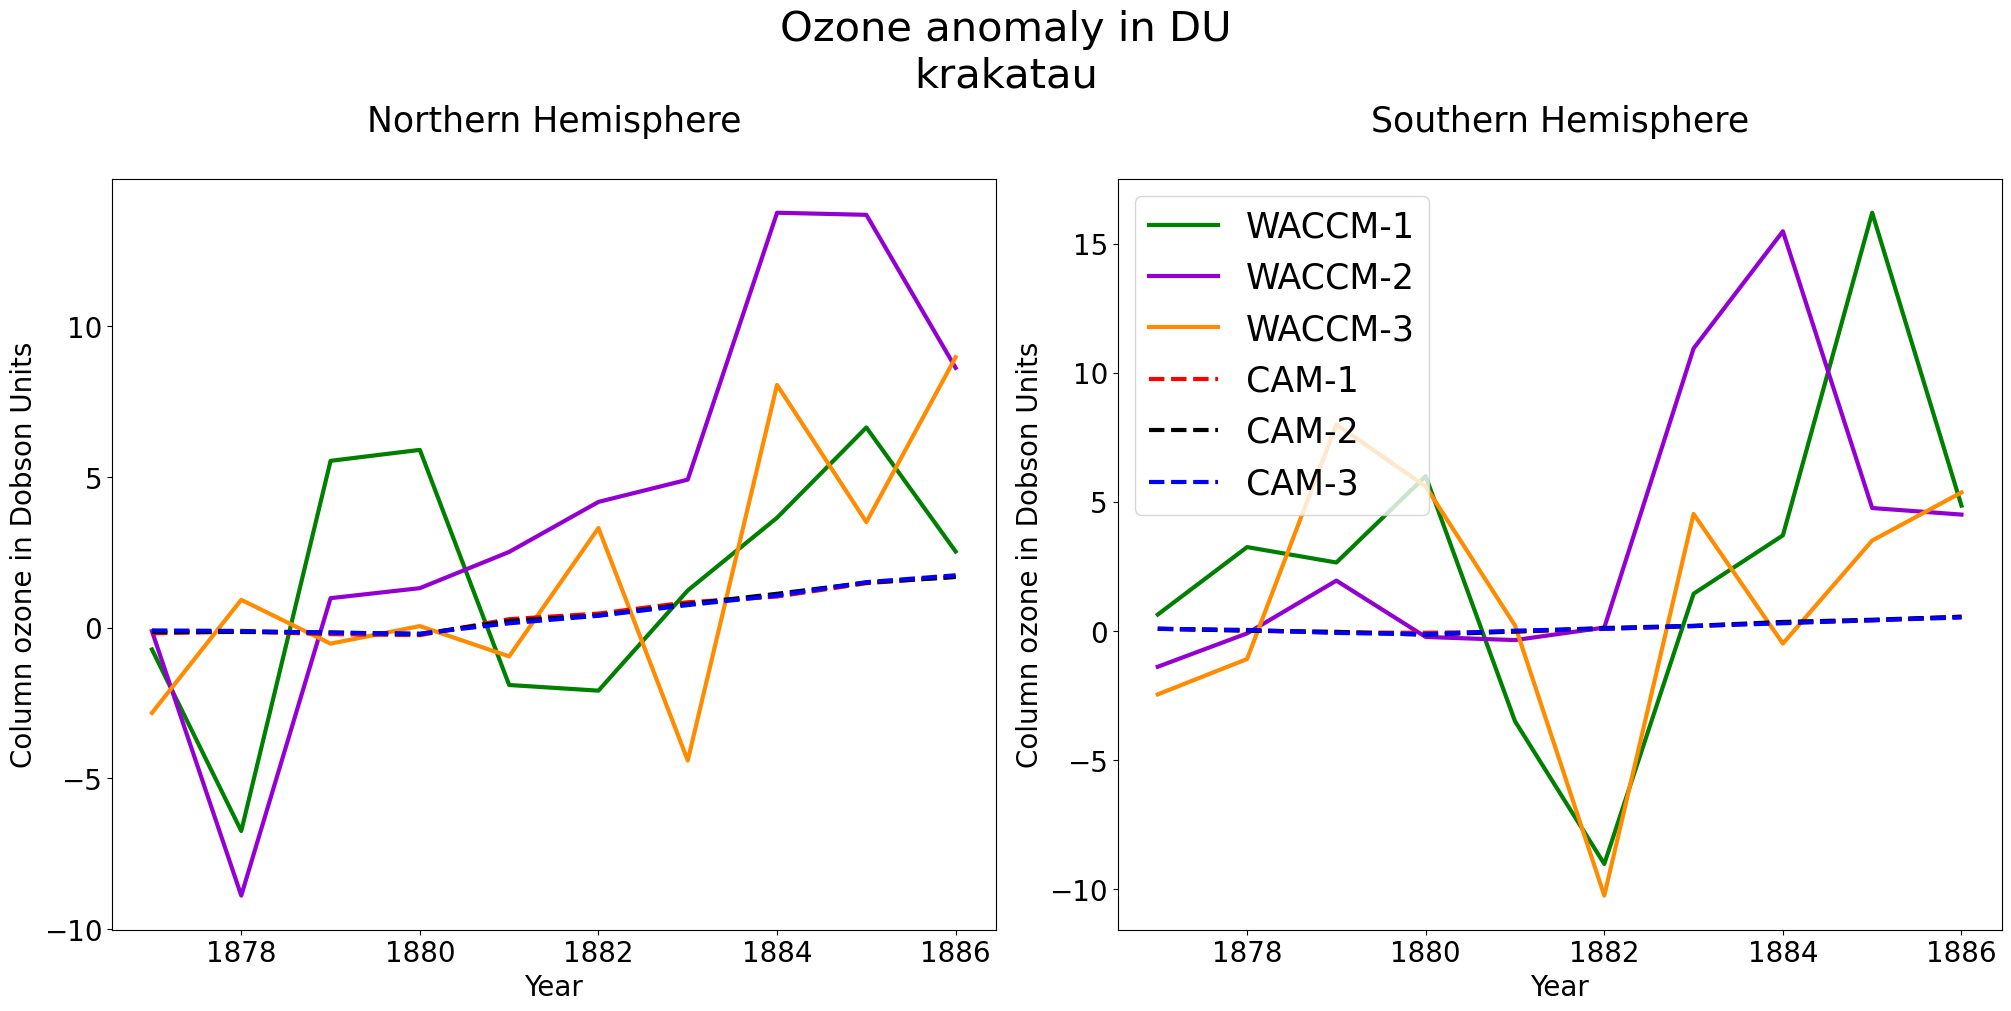

In [86]:
plot_year(waccm_wgt_NH_anom_krak, waccm_wgt_SH_anom_krak, cam_wgt_NH_anom_krak,cam_wgt_SH_anom_krak,'Ozone anomaly in DU \nKrakatoa')